# Vehicle Detection

The goal of this project is to implement a pipeline that is able to detect and track vehicles. In this project, the goal is not to use the best image processing and deep learning classification system but to use other Machine Learning supervised systems for detecting the vehicles.

The main goals of this projects are: 

* Build a Histogram of Oriented Gradients (HOG) as feature extraction to be used as training data for a supervised learning system.
* Implement a classification system that finds which windows are an image of a car.
* Implement a sliding window search to detect vehicles.
* Implement a system to consolidate multiple detections into one window
* Implement a pipeline with all previous steps.
* Run the pipeline through different videos, tracking the different vehicles.
* Run a second pipeline sequentially where we delimit the lanes.


In [1]:
import cv2
import glob
import numpy as np
import pickle

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

Number of car samples: 8792
Number of nocar samples: 10062


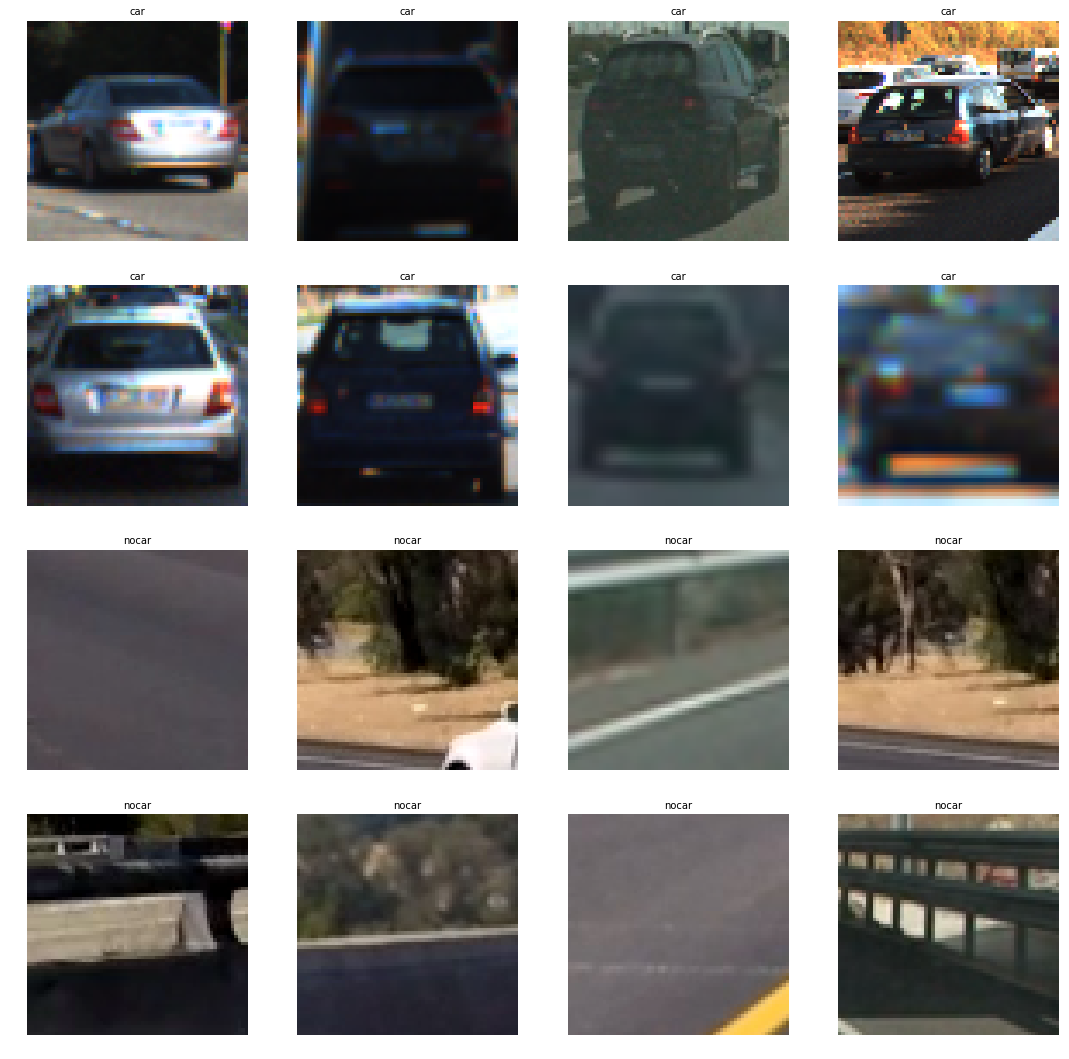

In [2]:
# Load and visualize input data
car_images = glob.glob('training_data/car/**/*.png')
no_car_images = glob.glob('training_data/nocar/**/*.png')

fig, axis = plt.subplots(4, 4, figsize=(16, 16))
axis = axis.ravel()
fig.subplots_adjust(0,0)

print("Number of car samples: {}\nNumber of nocar samples: {}".format(len(car_images), len(no_car_images)))

# Randomly plot some car and nocar images
for i in np.arange(8):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[i].axis('off')
    axis[i].set_title('car', fontsize=10)
    axis[i].imshow(img)
    
for i in np.arange(8,16):
    img = cv2.imread(no_car_images[np.random.randint(0,len(no_car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[i].axis('off')
    axis[i].set_title('nocar', fontsize=10)
    axis[i].imshow(img)

Both classes (cars and nocars) have similar amount of data, which should help with training.

## Build a Histogram of Oriented Gradients (HOG) as feature extraction to be used as training data for a supervised learning system

We can use scikit-image to compute the HOG of the images. There are a few of important parameters for the call to hog:

* Number of orientation bins (orientations) that the gradient information will be split up into.
* The cell size (pixels_per_cell) over which each gradient histogram is computed.
* Local area (cells_per_block) over which the histogram counts in a given cell will be normalized.

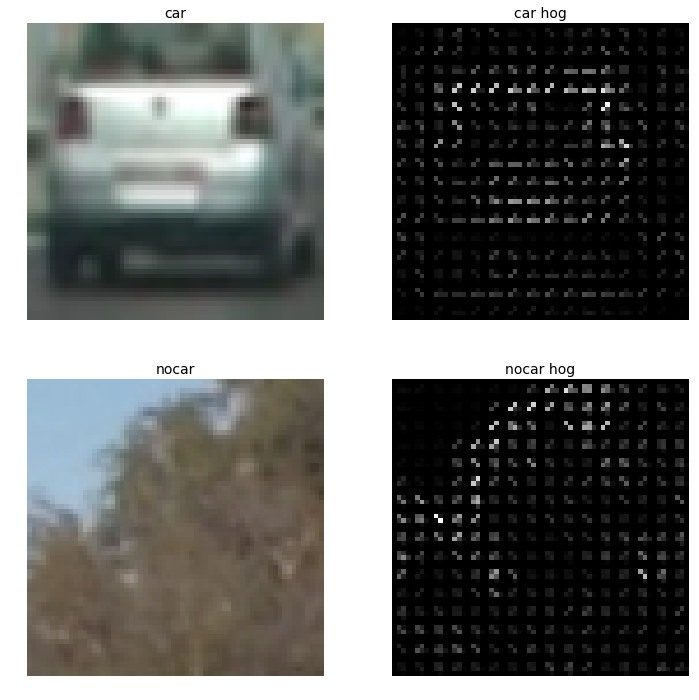

In [3]:
# orientations = 24
# pixel_per_cell = 4
# cell_per_block = 2
orientations = 16
pixel_per_cell = 4
cell_per_block = 2

def hog_features(img, visualise=False):
    """
    Gets the HOG features for the image given. If visualise is True, it also returns a HOG visualization image.
    """
    if visualise:
        return hog(
            img,
            orientations=orientations,
            pixels_per_cell=(pixel_per_cell, pixel_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            block_norm='L2-Hys',
            visualise=True,
            transform_sqrt=False)
    else:
        return hog(
            img,
            orientations=orientations,
            pixels_per_cell=(pixel_per_cell, pixel_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            block_norm='L2-Hys',
            visualise=False,
            transform_sqrt=False)
    
car_img = mpimg.imread(car_images[0])
gray_car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)

_, hog_car = hog_features(gray_car_img, True)
nocar_img = mpimg.imread(no_car_images[0])
gray_nocar_img = cv2.cvtColor(nocar_img, cv2.COLOR_RGB2GRAY)
_, hog_nocar = hog_features(gray_nocar_img, True)

f, axis = plt.subplots(2, 2, figsize=(12,12))
fig.subplots_adjust(0,0)
axis = axis.ravel()

axis[0].imshow(car_img)
axis[0].axis('off')
axis[0].set_title('car', fontsize=14)
axis[1].imshow(hog_car, cmap='gray')
axis[1].axis('off')
axis[1].set_title('car hog', fontsize=14)

axis[2].imshow(nocar_img)
axis[2].axis('off')
axis[2].set_title('nocar', fontsize=14)
axis[3].imshow(hog_nocar, cmap='gray')
axis[3].axis('off')
axis[3].set_title('nocar hog', fontsize=14)

After computing the HOG for each image, we need to extract features from the images to use on our classification problem.

We will be creating the training & test data from these features, with 0 and 1 as labels since this is a binary classification problem.

In other ML problems we have tackled until now we skipped this part because the system itself was generating this features (different layers on neural networks) without manual feature engineering so used in traditional ML.

In [4]:
def features(image_files, cspace='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0,256)):
    """
    Computes some features from the image files and concatenates them.
    The features used are spatial, histrogram and HOG (from a gray image).
    """
    feat = [] # List with features
    for file in image_files:
        image = mpimg.imread(file)
        image = (image*255).astype(np.uint8)
        features = []
        
        features.append(bin_spatial(image, cspace, size=spatial_size))
        features.append(color_hist(image, nbins=hist_bins, bins_range=hist_range))
        features.append(get_hog_features_single_image(image, cspace))
        # gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # features.append(hog_features(gray_image).ravel())
        
        # Flatten the list of lists
        features = [feature for sublist in features for feature in sublist]
        feat.append(features)
    return feat

def features_single_image(image, cspace='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0,256)):
    """
    Computes some features from a single image files and concatenates them.
    The features used are spatial, histrogram and HOG (from a gray image).
    """
    features = []
    features.append(bin_spatial(image, cspace, size=spatial_size))
    features.append(color_hist(image, nbins=hist_bins, bins_range=hist_range))
    features.append(get_hog_features_single_image(image, cspace))
        
    # Flatten the list of lists
    return [feature for sublist in features for feature in sublist]
        
def get_hog_features(imgs, cspace='RGB', hog_channel='ALL'):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        image = (image*255).astype(np.uint8)
        features.append(get_hog_features_single_image(image, cspace, hog_channel))
    return features

def get_hog_features_single_image(image, cspace='RGB', hog_channel='ALL'):
    features = []
    feature_image = transform(image, cspace)
    if hog_channel == 'ALL':
        for channel in range(feature_image.shape[2]):
            features.append(hog_features(feature_image[:,:,channel]))
        features = np.ravel(features)        
    else:
        features = hog_features(feature_image[:,:,channel])
    return features
    
def bin_spatial(image, cspace, size=(32,32)):
    feature_image = transform(image, cspace)
    return cv2.resize(feature_image, size).ravel()

def transform(image, cspace):
    if cspace == 'RGB':
        return np.copy(image)
    elif cspace == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        
def color_hist(image, nbins=32, bins_range=(0,256)):
    """
    Computes the histogram from the three channels of the image and returns its concatenation
    """
    ch1 = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ch2 = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    ch3 = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    return np.concatenate((ch1[0], ch2[0], ch3[0]))

In [5]:
from sklearn.preprocessing import StandardScaler

orientations = 16
pixel_per_cell = 8
cell_per_block = 2

def train_test_binary(class1_features, class2_features):
    X = np.vstack((class1_features, class2_features)).astype(np.float64)
    # X_scaler = StandardScaler().fit(X)
    # X_scaled = X_scaler.transform(X)
    # 1 -> label for car images.0 -> label for nocar images.
    y = np.hstack((np.ones(len(class1_features)), np.zeros(len(class2_features))))
    
    return train_test_split(X, y, test_size=0.33, random_state=5)

car_features = features(car_images, cspace='LUV')
nocar_features = features(no_car_images, cspace='LUV')

X_train, X_test, y_train, y_test = train_test_binary(car_features, nocar_features)

In [6]:
car_hog_rgb_features = get_hog_features(car_images, cspace='RGB')
nocar_hog_rgb_features = get_hog_features(no_car_images, cspace='RGB')
car_hog_hsv_features = get_hog_features(car_images, cspace='HSV')
nocar_hog_hsv_features = get_hog_features(no_car_images, cspace='HSV')
car_hog_luv_features = get_hog_features(car_images, cspace='LUV')
nocar_hog_luv_features = get_hog_features(no_car_images, cspace='LUV')
car_hog_hls_features = get_hog_features(car_images, cspace='HLS')
nocar_hog_hls_features = get_hog_features(no_car_images, cspace='HLS')
car_hog_yuv_features = get_hog_features(car_images, cspace='YUV')
nocar_hog_yuv_features = get_hog_features(no_car_images, cspace='YUV')
car_hog_ycrcb_features = get_hog_features(car_images, cspace='YCrCb')
nocar_hog_ycrcb_features = get_hog_features(no_car_images, cspace='YCrCb')

In [7]:
X_hog_rgb_train, X_hog_rgb_test, y_hog_rgb_train, y_hog_rgb_test = train_test_binary(car_hog_rgb_features, nocar_hog_rgb_features)
X_hog_hsv_train, X_hog_hsv_test, y_hog_hsv_train, y_hog_hsv_test = train_test_binary(car_hog_hsv_features, nocar_hog_hsv_features)
X_hog_luv_train, X_hog_luv_test, y_hog_luv_train, y_hog_luv_test = train_test_binary(car_hog_luv_features, nocar_hog_luv_features)
X_hog_hls_train, X_hog_hls_test, y_hog_hls_train, y_hog_hls_test = train_test_binary(car_hog_hls_features, nocar_hog_hls_features)
X_hog_yuv_train, X_hog_yuv_test, y_hog_yuv_train, y_hog_yuv_test = train_test_binary(car_hog_yuv_features, nocar_hog_yuv_features)
X_hog_ycrcb_train, X_hog_ycrcb_test, y_hog_ycrcb_train, y_hog_ycrcb_test = train_test_binary(car_hog_ycrcb_features, nocar_hog_ycrcb_features)

In [8]:
import pickle

train = {
    'X': X_train,
    'X_hog_rgb': X_hog_rgb_train,
    'X_hog_hsv': X_hog_hsv_train,
    'X_hog_luv': X_hog_luv_train,
    'X_hog_hls': X_hog_hls_train,
    'X_hog_yuv': X_hog_yuv_train,
    'X_hog_ycrcb': X_hog_ycrcb_train,
    'y': y_train,
    'y_hog_rgb': y_hog_rgb_train,
    'y_hog_hsv': y_hog_hsv_train,
    'y_hog_luv': y_hog_luv_train,
    'y_hog_hls': y_hog_hls_train,
    'y_hog_yuv': y_hog_yuv_train,
    'y_hog_ycrcb': y_hog_ycrcb_train,
}

test = {
    'X': X_test,
    'X_hog_rgb': X_hog_rgb_test,
    'X_hog_hsv': X_hog_hsv_test,
    'X_hog_luv': X_hog_luv_test,
    'X_hog_hls': X_hog_hls_test,
    'X_hog_yuv': X_hog_yuv_test,
    'X_hog_ycrcb': X_hog_ycrcb_test,
    'y': y_test,
    'y_hog_rgb': y_hog_rgb_test,
    'y_hog_hsv': y_hog_hsv_test,
    'y_hog_luv': y_hog_luv_test,
    'y_hog_hls': y_hog_hls_test,
    'y_hog_yuv': y_hog_yuv_test,
    'y_hog_ycrcb': y_hog_ycrcb_test,
}

with open('results/train_16_8_2.pickle', 'wb') as f:
    pickle.dump(train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('results/test_16_8_2.pickle', 'wb') as f:
    pickle.dump(test, f, protocol=pickle.HIGHEST_PROTOCOL)
    

In [75]:
train = pickle.load(open('results/train_24_16_2.pickle', 'rb'))
test = pickle.load(open('results/train_24_16_2.pickle', 'rb'))

## Implement a classification system that finds which windows are an image of a car

After we have curated the features from images we are using to train our model, we need to use some classification system to differentiate images from both classes. In this case, I am starting with a Linear Support Vector Machine; later on, depending on the results, we can consider using a different classifier (or combining multiple classifiers for this problem).

In [9]:
linear_svc = {
    'rgb': Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge'))]),
    'hsv': Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge'))]),
    'luv': Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge'))]),
    'hls': Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge'))]),
    'yuv': Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge'))]),
    'ycrcb': Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge'))]),
    'b_h_luv': Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge'))]),
}

linear_svc['b_h_luv'].fit(train['X'], train['y'])
print("Test accuracy: {:.4f}".format(100*linear_svc["b_h_luv"].score(test['X'], test['y'])))

linear_svc['rgb'].fit(train['X_hog_rgb'], train['y_hog_rgb'])
print("Test accuracy RGB: {:.2f}%".format(100*linear_svc['rgb'].score(test['X_hog_rgb'], test['y_hog_rgb'])))

linear_svc['hsv'].fit(train['X_hog_hsv'], train['y_hog_hsv'])
print("Test accuracy HSV: {:.2f}%".format(100*linear_svc['hsv'].score(test['X_hog_hsv'], test['y_hog_hsv'])))

linear_svc['luv'].fit(train['X_hog_luv'], train['y_hog_luv'])
print("Test accuracy LUV: {:.2f}%".format(100*linear_svc['luv'].score(test['X_hog_luv'], test['y_hog_luv'])))

linear_svc['hls'].fit(train['X_hog_hls'], train['y_hog_hls'])
print("Test accuracy HLS: {:.2f}%".format(100*linear_svc['hls'].score(test['X_hog_hls'], test['y_hog_hls'])))

linear_svc['yuv'].fit(train['X_hog_yuv'], train['y_hog_yuv'])
print("Test accuracy YUV: {:.2f}%".format(100*linear_svc['yuv'].score(test['X_hog_yuv'], test['y_hog_yuv'])))

linear_svc['ycrcb'].fit(train['X_hog_ycrcb'], train['y_hog_ycrcb'])
print("Test accuracy YCrCb: {:.2f}%".format(100*linear_svc['ycrcb'].score(test['X_hog_ycrcb'], test['y_hog_ycrcb'])))

Test accuracy: 99.1643
Test accuracy RGB: 93.01%
Test accuracy HSV: 94.94%
Test accuracy LUV: 97.86%
Test accuracy HLS: 94.79%
Test accuracy YUV: 97.85%
Test accuracy YCrCb: 98.04%


In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

clf = Pipeline([('scaling', StandardScaler()), ('classification', RandomForestClassifier(n_jobs=2))])
clf.fit(train['X_hog_yuv'], train['y_hog_yuv'])
print("Test accuracy Random Forest: {:.2f}%".format(100*clf.score(test['X_hog_yuv'], test['y_hog_yuv'])))

abc = Pipeline([('scaling', StandardScaler()), ('classification', AdaBoostClassifier())])
abc.fit(train['X_hog_luv'], train['y_hog_luv'])
print("Test accuracy AdaBoost: {:.2f}%".format(100*abc.score(test['X_hog_luv'], test['y_hog_luv'])))

Test accuracy Random Forest: 95.55%
Test accuracy AdaBoost: 96.79%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knc = Pipeline([('scaling', StandardScaler()), ('classification', KNeighborsClassifier(3))])
knc.fit(train['X_hog_yuv'], train['y_hog_yuv'])
print("Test accuracy AdaBoost: {:.2f}%".format(100*knc.score(test['X_hog_yuv'], test['y_hog_yuv'])))

In [89]:
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

train['X_hog_yuv_norm'] = normalize(train['X_hog_yuv'])
test['X_hog_yuv_norm'] = normalize(test['X_hog_yuv'])

In [ ]:
# Before training, I am limiting the GPU resource dedicated to training so I can test without killing the notebook server
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, ELU
from keras.optimizers import Adam
from keras import metrics

BATCH_SIZE = 32

def nn_model():
    model = Sequential()
    model.add(Dense(512, activation='elu', input_dim=12576))
    # model.add(Dense(512, activation='elu', input_dim=972))
    # model.add(Dense(512, activation='elu', input_dim=8460))
    model.add(Dense(128, activation='elu'))
    model.add(Dense(32, activation='elu'))
    model.add(Dense(16, activation='elu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
    
    return model

nn_scale = StandardScaler()
# nn_X_train = nn_scale.fit_transform(train['X_hog_yuv'])
# nn_X_test = nn_scale.fit_transform(test['X_hog_yuv'])
nn_X_train = nn_scale.fit_transform(train['X'])
nn_X_test = nn_scale.fit_transform(test['X'])

model_nn = nn_model()
model_nn.fit(nn_X_train,  train['y'], nb_epoch=5, batch_size=BATCH_SIZE)
model_nn.save('results/train_hist_spatial_yuv.nn_model')
score = model_nn.evaluate(nn_X_test, test['y'], batch_size=BATCH_SIZE)
print("\n{}".format(score))


## Implement a sliding window search to detect vehicles

Now we need to try to localize the vehicles in an image. To do this, we create multiple windows (different positions and sizes) in the image and try to detect vehicles in this windows.

We implement the sliding window search on part of the image (instead of the whole image (since we have some knowledge on where the horizon of the road is located)

In [36]:
def sliding_windows(img, x_start_stop=[None,None], y_start_stop=[None,None], window_size=(64,64), overlap=(0.5, 0.5)):
    """
    Returns a list of different windows.
    """
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(window_size[0] * (1 - overlap[0]))
    ny_pix_per_step = np.int(window_size[1] * (1 - overlap[1]))
    
    nx_buffer = np.int(window_size[0]*overlap[0])
    ny_buffer = np.int(window_size[1]*overlap[1])
    
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    
    windows = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + window_size[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + window_size[1]
            windows.append(((startx, starty), (endx, endy)))
        windows.append(((x_start_stop[1]-window_size[0], starty), (x_start_stop[1], endy)))
    return windows

def draw_windows(img, windows):
    image = np.copy(img)
    for window in windows:
        cv2.rectangle(image, window[0], window[1], (255,0,0), 4)
    return image

Next step is to implement a method that crops the image and resizes the images to be processed by one of the classifiers implemented below. 

In [42]:
def search_windows(img, windows, classifier, colorspace, is_nn=False):
    """
    Finds and returns the areas (from windows) that contain a specific class (using classifier).
    search_windows uses brute force and explores all the possible space of windows, and computes the hog features for each window.
    """
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))
        if is_nn:
            features = np.asarray(features_single_image(test_img, cspace=colorspace))
            # features = get_hog_features_single_image(test_img, cspace=colorspace)
            features = features.reshape(1,-1)
            features = nn_scale.transform(features)
            if classifier.predict(features)[0] > 0.8:
                on_windows.append(window)
        else:
            features = get_hog_features_single_image(test_img, cspace=colorspace)
            # features = features.reshape(1,-1)
            if classifier.predict(features)[0] == 1:
                on_windows.append(window)
    return on_windows

def find_cars(img, ystart, ystop, scale, classifier, X_scaler):
    """
    Finds and returns the areas (from windows) that contain a specific class (using classifier).
    find_cars optimizes the search to computes the hog features only once and reuses them for each window.
    """
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = transform("img_tosearch", "YCrCb")
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_to_search = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_to_search[:,:,0]
    ch2 = ctrans_to_search[:,:,1]
    ch3 = ctrans_to_search[:,:,2]
    
    nxblocks = (c1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (c1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orientation * cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = hog_features(ch1)
    hog2 = hog_features(ch2)
    hog3 = hog_features(ch3)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocs_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocs_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocs_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features))).reshape(-1, 1)
            test_prediction = svc.predict(test_features)           
#            if test_prediction == 1:

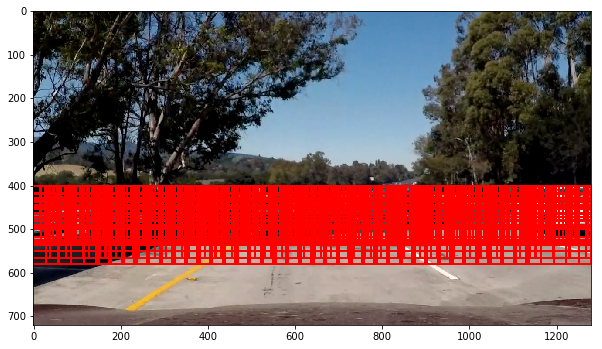

In [38]:
test_img = mpimg.imread('./test_images/test5.jpg')

possible_windows = sliding_windows(test_img, x_start_stop=[0,test_img.shape[1]], y_start_stop=[400, 550])
possible_windows += sliding_windows(test_img, x_start_stop=[0,test_img.shape[1]], y_start_stop=[400, 480], window_size=(32,32))
possible_windows += sliding_windows(test_img, x_start_stop=[0,test_img.shape[1]], y_start_stop=[400, 550], window_size=(45,45), overlap=(0.6,0.6))
possible_windows += sliding_windows(test_img, x_start_stop=[0, test_img.shape[1]], y_start_stop=[400,550], window_size=(96,96), overlap=(0.7,0.7))
possible_windows += sliding_windows(test_img, x_start_stop=[0, test_img.shape[1]], y_start_stop=[400,600], window_size=(128,128), overlap=(0.7,0.7))
possible_windows += sliding_windows(test_img, x_start_stop=[0, test_img.shape[1]], y_start_stop=[400,600], window_size=(150,150), overlap=(0.8,0.8))
# possible_windows += sliding_windows(test_img, x_start_stop=[0, test_img.shape[1]], y_start_stop=[350,600], window_size=(180,180), overlap=(0.7,0.7))
#possible_windows += sliding_windows(test_img, x_start_stop=[0, test_img.shape[1]], y_start_stop=[350,600], window_size=(200,200), overlap=(0.8, 0.8))

test_img_with_all_windows = draw_windows(test_img, possible_windows)

plt.figure(figsize=(10,10))
plt.imshow(test_img_with_all_windows)

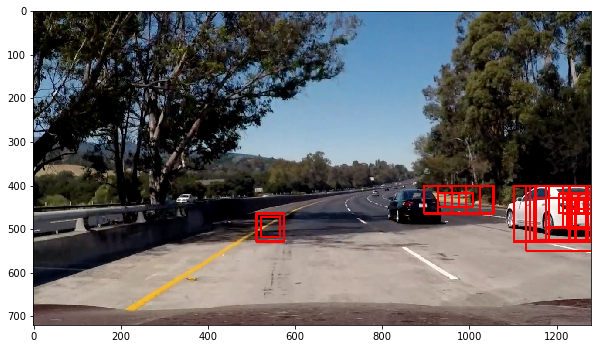

In [43]:
orientations = 16
pixel_per_cell = 8
cell_per_block = 2

on_windows = search_windows(test_img, possible_windows, model_nn, 'YUV', True)
# on_windows = search_windows(test_img, possible_windows, linear_svc['yuv'], 'YUV', False)

test_img_with_car_windows = draw_windows(test_img, on_windows)

plt.figure(figsize=(10,10))
plt.imshow(test_img_with_car_windows)


In [20]:
import scipy.misc

test_img_2 = mpimg.imread('./test/5.jpg')

path_save = "./training_data/nocar/extra_new/"

i = 0
for window in possible_windows:
    test_img = cv2.resize(test_img_2[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))
    scipy.misc.toimage(test_img).save(path_save + str(i) + ".png")
    # mpimg.imsave(path_save + str(i) + ".png", test_img, format='png')
    i += 1
    
#on_windows = search_windows(test_img_2, possible_windows, model_nn, 'YUV', True)

# on_windows = search_windows(test_img_2, possible_windows, linear_svc['b_h_luv'], 'LUV', True)

#test_img_with_car_windows = draw_windows(test_img_2, on_windows)

#plt.figure(figsize=(10,10))
#plt.imshow(test_img_with_car_windows)

Classifier result: [ 0.99645692] [ True]


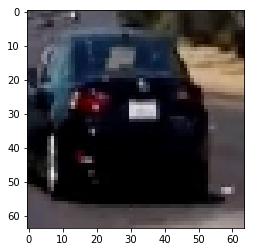

In [114]:
test_img_1 = cv2.resize(test_img[400:500,820:960], (64,64))
plt.figure()
plt.imshow(test_img_1)

features_test_1= np.asarray(get_hog_features_single_image(test_img_1, cspace='LUV'))
features_test_1 = features_test_1.reshape(1,-1)
features_test_1 = nn_scale.transform(features_test_1)

prediction_test_img_1 = model_nn.predict(features_test_1)[0]
print("Classifier result: {} {}".format(prediction_test_img_1, prediction_test_img_1 > 0.5))

## Implement a system to consolidate multiple detections into one window

For this part, I added the multiple windows into a heatmap and removing the falues below a certain threshold to remove false positives, while keeping multiple windows.

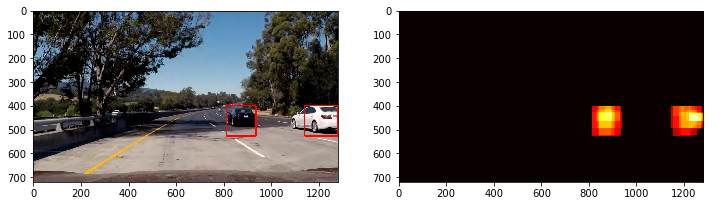

In [123]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, windows):
    for window in windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_windows(img, labels):
    for i in range(1, labels[1]+1):
        nonzero = (labels[0] == i).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        window = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, window[0], window[1], (255,0,0), 4)
    return img
                      

heat = np.zeros_like(test_img[:,:,0]).astype(np.int64)
heat = add_heat(heat, on_windows)
heat = apply_threshold(heat, 4)

heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)

draw_img = draw_labeled_windows(np.copy(test_img), labels)

fig = plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(draw_img)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')

## Implement a pipeline with all previous steps.

In [124]:
def detect_vehicle_pipeline(image, windows):
    on_windows = search_windows(image, windows, model_nn, 'LUV', True)
    heat = np.zeros_like(image[:,:,0]).astype(np.int64)
    heat = add_heat(heat, on_windows)
    heat = apply_threshold(heat, 4)
    labels = label(heat)
    
    return draw_labeled_windows(np.copy(image), labels)

## Run the pipeline through different videos, tracking the different vehicles.

In [119]:
from moviepy.editor import VideoFileClip

state = {}
state['all_windows'] = possible_windows
state['heatmap'] = None


output = 'results/test_video_vehicles.mp4'
clip = VideoFileClip('test_video.mp4')

vid_clip = clip.fl_image(lambda x: detect_vehicle_pipeline(x, possible_windows))
%time vid_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video results/test_video_vehicles.mp4
[MoviePy] Writing video results/test_video_vehicles.mp4


 97%|█████████▋| 38/39 [00:51<00:01,  1.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/test_video_vehicles.mp4 

CPU times: user 56.3 s, sys: 1.91 s, total: 58.2 s
Wall time: 52.3 s


In [125]:
output = 'results/project_video_vehicles.mp4'
clip = VideoFileClip('project_video.mp4')

vid_clip = clip.fl_image(lambda x: detect_vehicle_pipeline(x, possible_windows))
vid_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video results/project_video_vehicles.mp4
[MoviePy] Writing video results/project_video_vehicles.mp4


100%|█████████▉| 1260/1261 [1:46:10<00:05,  5.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/project_video_vehicles.mp4 

